<a href="https://colab.research.google.com/github/FrancescoMonaco/LFN_Project/blob/main/LFN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Data Retrieval
gt : graph-tool\
nx : networkx\
go: plotly


In [ ]:
#@title Libraries install
%%capture
! python -m pip install snap-stanford
!pip install nilearn
!pip install plotly
!pip install python-louvain

In [ ]:
#@title Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#*** Libraries to manipulate fMRI data
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from nilearn.input_data import NiftiLabelsMasker
#*** Libraries for graphs
import networkx as nx
#import snap
#from graph_tool.all import *
#*** Basic imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import gc, os
from tqdm import tqdm
import scipy.stats as stats
#*** Scaler for the data
from sklearn.preprocessing import StandardScaler
#*** Multiprocessing tools
import multiprocessing
from multiprocessing import Pool

# Install the python-louvain package

from community import community_louvain
import networkx as nx
import matplotlib.cm as cm


In [24]:
#@title Imports from external py files
import requests
base_url = "raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main"
files_to_download = ["graph_metrics.py", "findpartitionofbrain.py", "mri_to_graph.py"]
for file_name in files_to_download:
      file_url = f"{base_url}/{file_name}"
      !wget {file_url}
from graph_metrics import *
from mri_to_graph import *
from findpartitionofbrain import *

URL transformed to HTTPS due to an HSTS policy
--2023-11-26 10:04:15--  https://raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main/graph_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3804 (3.7K) [text/plain]
Saving to: ‘graph_metrics.py’

graph_metrics.py    100%[===================>]   3.71K  --.-KB/s    in 0s      

2023-11-26 10:04:15 (21.0 MB/s) - ‘graph_metrics.py’ saved [3804/3804]

URL transformed to HTTPS due to an HSTS policy
--2023-11-26 10:04:15--  https://raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main/findpartitionofbrain.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

In [26]:
#@title Use precomputed graphs (IF YES SKIP TO TEST AREA DIRECTLY)
%%capture
prec = True # @param {type:"boolean"}
if prec:
  import requests
  import pickle
  base_url = "raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main"
  files_to_download = ["adhd_data.pkl", "control_data.pkl", "bp_data.pkl", "schz_data.pkl"]

# Download each file
  for file_name in files_to_download:
      file_url = f"{base_url}/{file_name}"
      !wget {file_url}
  # Load dataframes with graphs using Pickle
  with open('/content/control_data.pkl', 'rb') as file:
      control_data = pickle.load(file)

  with open('/content/schz_data.pkl', 'rb') as file:
      schz_data = pickle.load(file)

  with open('/content/bp_data.pkl', 'rb') as file:
      bp_data = pickle.load(file)

  with open('/content/adhd_data.pkl', 'rb') as file:
      adhd_data = pickle.load(file)


In [ ]:
#@title Data download
%%capture
# Load the brain atlas
atlas = datasets.fetch_atlas_msdl()
# Load the atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Load atlas data stored in 'labels'
labels = atlas["labels"]

# Load the dataset
_, urls = datasets.fetch_ds000030_urls()

selected_subjects = [
    'sub-10159', 'sub-10171', 'sub-10189', 'sub-10206', 'sub-10217',
    'sub-10292', 'sub-10524', 'sub-10316', 'sub-10940', 'sub-11156',
    'sub-50004', 'sub-50005', 'sub-50006', 'sub-50007', 'sub-50008',
    'sub-50010', 'sub-50013', 'sub-50014', 'sub-50015', 'sub-50016',
    'sub-60001', 'sub-60005', 'sub-60006', 'sub-60008', 'sub-60010',
    'sub-60011', 'sub-60012', 'sub-60014', 'sub-60015', 'sub-60016',
    'sub-70017', 'sub-70020', 'sub-70021', 'sub-70022', 'sub-70026',
    'sub-70029', 'sub-70033', 'sub-70034', 'sub-70083', 'sub-70086'
]

filtered_urls = [url for url in urls if any(subject in url for subject in selected_subjects)]

# Define exclusion patterns to exclude unwanted data
exclusion_patterns = [
    "*/freesurfer/*"
    "*derivatives/task*",
    "*task_group*",
    "*/anat/*",
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-pamenc*",
    "*task-pamret*",
    "*task-scap*",
    "*task-task*",
    "*task-stopsignal*",
    "*task-bht*"
]

# Apply the filters to select subjects and exclude unwanted data
urls = datasets.select_from_index(
    filtered_urls, exclusion_filters=exclusion_patterns
)

try:
    # Fetch the selected subjects' data
    data_dir, _ = datasets.fetch_openneuro_dataset(urls=urls)
except Exception as e:
    print(f"Finished, except: {e}")


In [ ]:
#@title Variables for data retrieval and manipulation
base_path = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/"

# Dataframes
cols = ['data', 'confounds', 'graph', 'nodes', 'edges']
control_data = pd.DataFrame(columns=cols)
schz_data = pd.DataFrame(columns=cols)
bp_data = pd.DataFrame(columns=cols)
adhd_data = pd.DataFrame(columns=cols)

# Visit each subject's folder
for subject_folder in os.scandir(base_path):
    if subject_folder.is_dir():
        condition = subject_folder.name[4]  # Extract the condition from the subject id

        # Variables
        data_path = None
        confounds_data = None

        # Retrieve the data

        func_path = os.path.join(subject_folder.path, "func")
        for func_file in os.scandir(func_path):
          # Find the confounds variables file
              if func_file.name.endswith(".tsv"):
                    confounds_data = pd.read_csv(func_file.path, sep='\t')
          # Find the resting state fmri
              if func_file.name.endswith("preproc.nii.gz"):
                    data_path = func_file.path

        # Add data to the respective dataframe
        if condition == "1":
            control_data.loc[len(control_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "5":
            schz_data.loc[len(schz_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "6":
            bp_data.loc[len(bp_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "7":
            adhd_data.loc[len(adhd_data)] = [data_path, confounds_data, None, None, None]



# MRI to Graph

In [ ]:
#@title Load brain atlas
import nibabel as nib
schaefer_1000 = datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7, resolution_mm=1, verbose=1)

# Load the atlas data
atlas_img = nib.load(schaefer_1000.maps)

# ROIs coordinates
coords = np.vstack(np.where(atlas_img.get_fdata() > 0)).T

In [ ]:
#@title Transform loop
dataframes = [control_data, schz_data, bp_data, adhd_data]

# Create processors for the data

  # Timeseries extractor
spheres_masker = NiftiLabelsMasker(
    labels_img=schaefer_1000.maps,
    smoothing_fwhm=1,
    detrend=True,
    standardize="zscore_sample",
    t_r=None
)

threshold = 0.25 # @param {type:"slider", min:0, max:1, step:0.01}

# Wrapper for the dataframes
dataframes = [control_data, schz_data, bp_data, adhd_data]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]
num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

# Execution
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        process_dataframe,
        [(dataframe, condition, spheres_masker, threshold) for dataframe, condition in zip(dataframes, conditions)]
    )

for df, results in zip(dataframes, processed_data):
    for result in results:
        row_name, G, num_nodes, num_edges = result
        df.at[row_name, 'graph'] = G
        df.at[row_name, 'nodes'] = num_nodes
        df.at[row_name, 'edges'] = num_edges




100%|██████████| 10/10 [02:16<00:00, 13.64s/it]


In [ ]:
#@title Compute mean number of nodes and edges
# Concatenate all dataframes into one
combined_data = pd.concat(dataframes)

# Calculate the mean number of nodes and edges
mean_nodes = combined_data['nodes'].mean()
mean_edges = combined_data['edges'].mean()

print(f"Mean Nodes: {mean_nodes}")
print(f"Mean Edges: {mean_edges}")

# Run garbage collection
del mean_nodes, mean_edges, spheres_masker, combined_data
gc.collect()

Mean Nodes: 456.325
Mean Edges: 1249.0


0

# Test Area

##Plot test


Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


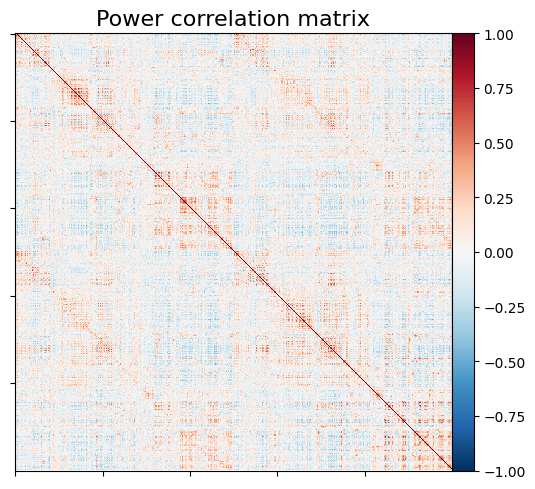

In [ ]:
import nibabel as nib
schaefer_1000 = datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7, resolution_mm=1, verbose=1)

# Load the atlas data
atlas_img = nib.load(schaefer_1000.maps)

# ROIs coordinates
coords = plotting.find_parcellation_cut_coords(atlas_img)
#coords = np.vstack(np.where(atlas_img.get_fdata() > 0)).T

# Timeseries extractor
spheres_masker = NiftiLabelsMasker(
    labels_img=schaefer_1000.maps,
    smoothing_fwhm=1,
    detrend=True,
    standardize="zscore_sample",
    t_r=None
)


sample_row = control_data.iloc[0]  # Change the index (0) to the desired sample

data_path = sample_row['data']
confounds_data = sample_row['confounds']

# Perform preprocessing on confounds_data if needed
confounds_data = confounds_data.replace([np.nan, np.inf, -np.inf], 0)
timeseries = spheres_masker.fit_transform(data_path, confounds=confounds_data)

scaler = StandardScaler()

# Apply Z-score normalization to your time series data
timeseries_normalized = scaler.fit_transform(timeseries)

correlation_matrix = np.corrcoef(timeseries_normalized, rowvar=False)

# CONNECTOME MATRIX PLOTTING
plotting.plot_matrix(
    correlation_matrix,
    vmin=-1.0,
    vmax=1.0,
    colorbar=True,
    title="Power correlation matrix",
)

In [ ]:
display =plotting.plot_connectome(
    correlation_matrix,
    coords,
    title="Power correlation graph",
    edge_threshold="99.96%",
    node_size=0.5,
    colorbar=True,
)

In [ ]:
# @title Testo del titolo predefinito
power_correlation_matrix = correlation_matrix
G = nx.Graph()
n = power_correlation_matrix.shape[0]  # Number of brain regions

n = power_correlation_matrix.shape[0]
mask = ~np.eye(n, dtype=bool)

# Calculate the threshold based on the top 0.2% of values, excluding the diagonal
# Flatten the correlation matrix, excluding the diagonal
values = power_correlation_matrix[mask].flatten()

# Sort the values in descending order
sorted_values = np.sort(values)[::-1]

# Calculate the threshold
top_percentage = 0.5
threshold_idx = int(len(sorted_values) * top_percentage / 100)
threshold = sorted_values[threshold_idx]

for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        if abs(correlation_matrix[i, j]) >= threshold:
            G.add_edge(i, j)



In [ ]:
G = control_data.at[9, 'graph']

pos = nx.spring_layout(G)
node_degrees = dict(G.degree())


# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure with size proportional to degree
for node, (x, y) in pos.items():
    fig.add_trace(go.Scatter(x=[x], y=[y], mode="markers", marker=dict(size=1 * node_degrees[node], opacity=0.7), name=str(node_degrees[node])))

# Add edges to the figure
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=0.5)))

# Customize the figure further as needed

# Show the interactive plot
fig.show()


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(node_degrees.values()) / num_nodes

# Print the results
print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Average Degree:", average_degree)

Number of Nodes: 499
Number of Edges: 1249
Average Degree: 5.006012024048096


## Metrics test

In [ ]:
#@title Create random graphs using the same degree frequencies found in the original ones
dataframes = [control_data, schz_data, bp_data, adhd_data]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]

rand_grp = pd.DataFrame(columns=['graph'])

for dataframe, condition in zip(dataframes,conditions):
  for original_graph in dataframe['graph']:
    # Get the degree sequence
      degree_sequence = [degree for _, degree in original_graph.degree()]
    # Generate multiple random graphs based on the same degree sequence
      random_graph = nx.Graph(nx.configuration_model(degree_sequence, create_using=nx.Graph()))
    # Add the random graph to the DataFrame
      rand_grp = rand_grp.append({'graph':random_graph}, ignore_index=True)

In [ ]:
#@title Functions to process the data

# Centralities
def process_graph_centralities(G):
    """
    Calculate centrality measures for a graph and extract top 5 nodes for each measure.

    Parameters:
    - G (networkx.Graph): Input graph.

    Returns:
    Tuple containing:
    1. Mean closeness centrality of the entire graph.
    2. Mean betweenness centrality of the entire graph.
    3. Mean degree centrality of the entire graph.
    4. Average clustering coefficient of the entire graph.
    5. List of values for the top 5 nodes based on closeness centrality.
    6. List of values for the top 5 nodes based on betweenness centrality.
    7. List of values for the top 5 nodes based on degree centrality.
    8. List of values for the top 5 nodes based on clustering coefficient.
    """

    num_nodes = G.number_of_nodes()

    closeness = nx.closeness_centrality(G)

    betweenness = nx.betweenness_centrality(G)

    degree = dict(G.degree())

    clustering = nx.clustering(G)

    # Sort nodes based on centrality measures
    top_nodes_closeness = sorted(closeness, key=closeness.get, reverse=True)[:5]
    top_nodes_betweenness = sorted(betweenness, key=betweenness.get, reverse=True)[:5]
    top_nodes_degree = sorted(degree, key=degree.get, reverse=True)[:5]
    top_nodes_clustering = sorted(clustering, key=clustering.get, reverse=True)[:5]
    # Extract their values
    values_top_nodes_closeness = np.mean([closeness[node] for node in top_nodes_closeness])
    values_top_nodes_betweenness = np.mean([betweenness[node] for node in top_nodes_betweenness])
    values_top_nodes_degree = np.mean([degree[node] for node in top_nodes_degree])
    values_top_nodes_clustering = np.mean([clustering[node] for node in top_nodes_clustering])
    # Mean on the graph
    m_degree = sum(degree.values())/num_nodes
    m_closeness = sum(closeness.values())/num_nodes
    m_betweenness = sum(betweenness.values())/num_nodes
    avg_clust = nx.average_clustering(G)

    return (m_closeness, m_betweenness, m_degree, avg_clust,
                    values_top_nodes_closeness,
                    values_top_nodes_betweenness,
                    values_top_nodes_degree,
                    values_top_nodes_clustering)

# Efficiency metrics
def global_brain_efficiency(G):
  return nx.global_efficiency(G)

def network_cost(G):
  n_edges=G.number_of_edges()
  n_nodes=G.number_of_nodes()
  binomial_coefficient = (stats.binom(n_nodes, 2)).pmf(2)
  return n_edges/binomial_coefficient

def process_graph_modularity(G):
  modularity = nx.community.modularity(G, nx.community.label_propagation_communities(G))
  return modularity

def process_graphs(dataframe, condition):
    results = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        G = row['graph']

        # Mean centralities and top 5 values
        (m_closeness, m_betweenness, m_degree, avg_clust,
        values_top_nodes_closeness, values_top_nodes_betweenness,
        values_top_nodes_degree, values_top_nodes_clustering,
        ) = process_graph_centralities(G)

        # Modularity, costs
        modularity = process_graph_modularity(G)
        gbe = global_brain_efficiency(G)
        nc = network_cost(G) #launches an error, needs to be checked

        #Put results in the result df
        results.append((row.name, m_closeness, m_betweenness, m_degree, avg_clust,
                        values_top_nodes_closeness, values_top_nodes_betweenness,
                        values_top_nodes_degree, values_top_nodes_clustering,
                        modularity, gbe, nc))
    return results

In [ ]:
#@title Processing cycle
# Wrapper for the dataframes
dataframes = [control_data, schz_data, bp_data, adhd_data, rand_grp]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD", "Random"]
num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

# Execution
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        process_graphs,
        [(dataframe, condition) for dataframe, condition in zip(dataframes, conditions)]
    )

for df, results in zip(dataframes, processed_data):
    for result in results:
        (row_name, m_closeness, m_betweenness, m_degree, avg_clust,
            top5_close, top5_betw,
            top5_deg, top5_clust,
            modularity, gbe,nc) = result

        df.at[row_name, 'closeness'] = m_closeness
        df.at[row_name, 'betweenness'] = m_betweenness
        df.at[row_name, 'degree'] = m_degree
        df.at[row_name, 'clustering'] = avg_clust
        df.at[row_name,'top5_close'] = top5_close
        df.at[row_name,'top5_betw'] = top5_betw
        df.at[row_name,'top5_deg'] = top5_deg
        df.at[row_name,'top5_clust'] = top5_clust
        df.at[row_name, 'modularity'] = modularity
        df.at[row_name, 'global_efficiency'] = gbe
        df.at[row_name, 'network_cost'] = nc


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


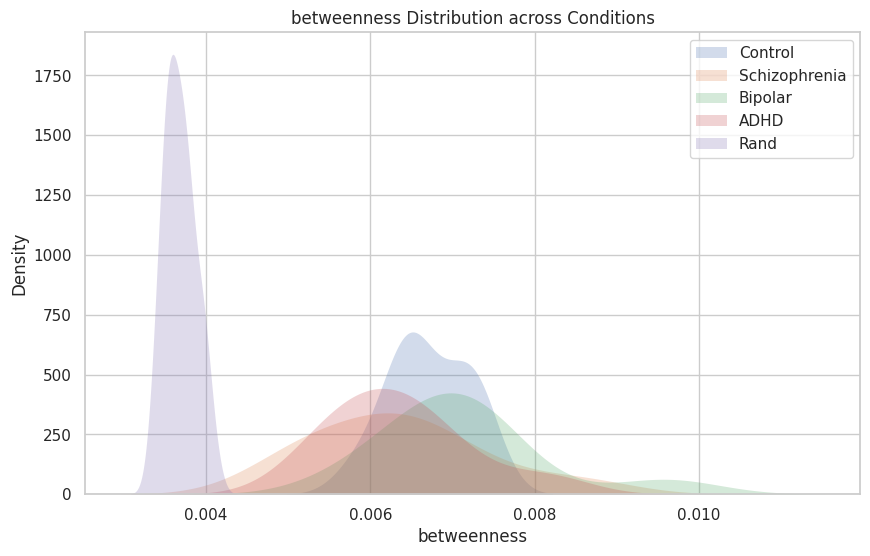

In [ ]:
#@title Probability distributions plotter
feature = "betweenness" # @param ["global_efficiency", "closeness", "betweenness", "degree", "top5_deg", "top5_close", "top5_betw", "clustering", "degree"]
# Set the style
sns.set(style="whitegrid")

# Plotting distributions with KDE and best-fit line
plt.figure(figsize=(10, 6))

# Control
sns.kdeplot(control_data[feature], label='Control', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# Schizophrenia
sns.kdeplot(schz_data[feature], label='Schizophrenia', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# Bipolar
sns.kdeplot(bp_data[feature], label='Bipolar', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# ADHD
sns.kdeplot(adhd_data[feature], label='ADHD', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

sns.kdeplot(rand_grp[feature], label='Rand', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# Adding labels and title
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(feature + ' Distribution across Conditions')

# Adding legend
plt.legend()

# Show the plot
plt.show()


##z-score, p-values computation

In [ ]:
#@title Features values
from scipy.stats import ttest_ind, zscore

def calculate_zscores(group, mean, std):
    return (group - mean) / std

feature = "degree" # @param ["global_efficiency", "closeness", "betweenness", "degree", "top5_deg", "top5_close", "top5_betw", "clustering", "degree"]

# Extract the feature of interest
control_global_efficiency = control_data[feature]
schz_global_efficiency = schz_data[feature]
bp_global_efficiency = bp_data[feature]
adhd_global_efficiency = adhd_data[feature]
rand_global_efficiency = rand_grp[feature]

schz_zscores_vs_random = calculate_zscores(schz_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
bp_zscores_vs_random = calculate_zscores(bp_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
adhd_zscores_vs_random = calculate_zscores(adhd_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
control_zscores_vs_random = calculate_zscores(control_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
rand_zscores = calculate_zscores(rand_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())

# Perform t-tests between each group and the random group
t_stat_schz_vs_random, p_value_schz_vs_random = ttest_ind(schz_zscores_vs_random, rand_zscores, equal_var=False)
t_stat_bp_vs_random, p_value_bp_vs_random = ttest_ind(bp_zscores_vs_random, rand_zscores, equal_var=False)
t_stat_adhd_vs_random, p_value_adhd_vs_random = ttest_ind(adhd_zscores_vs_random, rand_zscores, equal_var=False)
t_stat_control_vs_random, p_value_control_vs_random = ttest_ind(control_zscores_vs_random, rand_zscores, equal_var=False)

# Print or use the p-values as needed
print("p-value Schizophrenia vs. Random: {:.3f}".format(p_value_schz_vs_random))
print("p-value Bipolar vs. Random: {:.3f}".format(p_value_bp_vs_random))
print("p-value ADHD vs. Random: {:.3f}".format(p_value_adhd_vs_random))
print("p-value Control vs. Random: {:.3f}".format(p_value_control_vs_random))

p-value Schizophrenia vs. Random: 0.627
p-value Bipolar vs. Random: 0.398
p-value ADHD vs. Random: 0.581
p-value Control vs. Random: 0.563


In [ ]:
!pip install python-igraph
from igraph import Graph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.5 MB/s eta 0:00:00


In [ ]:
import igraph as ig
import networkx as nx

# Selecting a single row for demonstration purposes
selected_row = control_data.iloc[0]

# Extracting the NetworkX graph from the 'graph' column
nx_graph = selected_row['graph']

# Convert the NetworkX graph to an iGraph graph
ig_graph = ig.Graph.Adjacency((nx.to_numpy_array(nx_graph) > 0).tolist())

# Set the maximum motif size
max_motif_size = 4

# Count motifs for all motifs up to size k
motif_counts = ig_graph.motifs_randesu(max_motif_size)

# Print the motif counts
print("Motif counts:")
for i, count in enumerate(motif_counts):
    print(f"Motif {i+1}: {count}")


#Save, upload zone

In [ ]:
#@title Save dataframes as csv?
save_data = True # @param {type:"boolean"}
if save_data:
      import pickle

      # Save dataframes with graphs using Pickle
      with open('/content/control_data.pkl', 'wb') as file:
          pickle.dump(control_data, file)

      with open('/content/schz_data.pkl', 'wb') as file:
          pickle.dump(schz_data, file)

      with open('/content/bp_data.pkl', 'wb') as file:
          pickle.dump(bp_data, file)

      with open('/content/adhd_data.pkl', 'wb') as file:
          pickle.dump(adhd_data, file)
      print('Dataframes saved!')

download_data = True # @param {type:"boolean"}
if download_data:
  from google.colab import files
  zip_file = '/content/dataframes.zip'
  !zip -r dataframes.zip /content/control_data.pkl /content/schz_data.pkl /content/bp_data.pkl /content/adhd_data.pkl
  files.download(zip_file)

Dataframes saved!
  adding: content/control_data.pkl (deflated 37%)
  adding: content/schz_data.pkl (deflated 37%)
  adding: content/bp_data.pkl (deflated 37%)
  adding: content/adhd_data.pkl (deflated 37%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>